In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ftplib
import io
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

Read in csv from NOAA ftp server:

Citation: <br>
Burtner, Ashley; Palladino, Danna; Kitchens, Christine; Fyffe, Deanna; Johengen, Tom; Stuart, Dack; Cooperative Institute for Great Lakes Research, University of Michigan; Fanslow, David; Gossiaux, Duane; National Oceanic and Atmospheric Administration; Great Lakes Environmental Research Laboratory (2019). Physical, chemical, and biological water quality data collected from a small boat in western Lake Erie, Great Lakes from 2012-05-15 to 2018-10-09 (NCEI Accession 0187718). NOAA National Centers for Environmental Information. Dataset. https://accession.nodc.noaa.gov/0187718. Accessed 06-14-2020.

In [2]:
ftp = ftplib.FTP("ftp.nodc.noaa.gov")
ftp.login()
ftp.cwd("nodc/archive/arc0135/0187718/2.2/data/0-data/")
ftp.nlst()
download_file = io.BytesIO()
ftp.retrbinary('RETR lake_erie_habs_field_sampling_results_2012_2018_v2.csv', download_file.write)
download_file.seek(0)
data = pd.read_csv(download_file, engine='python', encoding = "ISO-8859-1")
ftp.quit()

'221 Goodbye.'

List exogenous variables to use in model. These are all physical/chemical properties of the water sample.
Endogenous variable is Particulate Microcystin (µg/L). This is the measure of the algae toxins contained.

In [3]:
columns = [
    'Particulate Microcystin (µg/L)',
    'Extracted Phycocyanin (µg/L)',
    'Extracted Chlorophyll a (µg/L)',
    'CTD Dissolved Oxygen (mg/L)',
    'CTD Specific Conductivity (µS/cm)',
    'CTD Photosynthetically Active Radiation (µE/m2/s)',
    'CTD Temperature (°C)',
    'CTD Tramission (%)',
    'CTD Beam Attenuation (m-1)',
    'Ammonia (µg N/L)',
    'Soluble Reactive Phosphorus (µg P/L)',
    'Nitrate + Nitrite (mg N/L)',
    'Total Dissolved Phosphorus (µg P/L)',
    'Particulate Organic Carbon (mg/L)',
    'Total Phosphorus (µg P/L)',
    'Particulate Organic Nitrogen (mg/L)',
    'Volatile Suspended Solids (mg/L)',
    'Total Suspended Solids (mg/L)'
]

Cast null values where values are blank or 'nd'.

In [4]:
for column in columns:
    if ' ' in data[column].unique() or 'nd' in data[column].unique():
        data.loc[data[column].isin([' ', 'nd']), column] = np.nan
        try:
            data[column] = data[column].astype('float64')
        except:
            pass

/home/marinbak/miniconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


List columns that have < in their values.

In [5]:
for column in columns:
    if data[column].dtype != 'float64':
        print(column)
        print(data.loc[data[column].str.contains("<").fillna(False), column].unique())

Particulate Microcystin (µg/L)
['<0.1']
Extracted Phycocyanin (µg/L)
['<0.036' '<0.06' '<0.36' '<0.9' '<0.45' '<1.8' '<0.6' '<40' '<0.03']
Ammonia (µg N/L)
['<0.04' '<0.4']
Soluble Reactive Phosphorus (µg P/L)
['<0.25']
Nitrate + Nitrite (mg N/L)
['<0.002']


Define functions to either replace "<x" values with zeros or with the value without the "<".

In [6]:
def zero_less_thans(df, column, zero_thres):
    df.loc[df[column] == zero_thres, column] = 0

In [7]:
def fill_less_thans(df, column):
    df.loc[df[column].str.contains("<").fillna(False), column] = df.loc[df[column].str.contains("<").fillna(False), column].str.replace("<", "")

For all columns containing "<x" value, replace the smallest "<x" value with zero, and replace others with x, <br>
except 'Ammonia (µg N/L)', since '<0.4' is probably a transcription error of '0.04' so replace both with zeros.

In [8]:
zero_less_thans(data, 'Particulate Microcystin (µg/L)', '<0.1')
zero_less_thans(data, 'Extracted Phycocyanin (µg/L)', '<0.03')
zero_less_thans(data, 'Ammonia (µg N/L)', '<0.04')
zero_less_thans(data, 'Ammonia (µg N/L)', '<0.4')
zero_less_thans(data, 'Soluble Reactive Phosphorus (µg P/L)', '<0.25')
zero_less_thans(data, 'Nitrate + Nitrite (mg N/L)', '<0.002')

fill_less_thans(data, 'Extracted Phycocyanin (µg/L)')

Drop row with anomalous and inconsistent Particulate Microcystin measurement.

In [9]:
data.drop(data[data['Particulate Microcystin (µg/L)'] == '2778.75 ± 294'].index, inplace = True)

Cast all columns of interest as type float.

In [10]:
for column in columns:
    if data[column].dtype != 'float64':
        try:
            data[column] = data[column].astype('float64')
        except:
            print(column)

Make time series of observations at site WE2.

In [11]:
ts = data[data['Site'] == 'WE2'].copy().drop_duplicates(subset = 'Date')

ts.set_index(pd.to_datetime(ts['Date']), inplace = True)

ts = ts.loc[ts['Site'] == 'WE2'][columns].interpolate(method = 'time').dropna()

Resample and interpolate to force weekly frequency on time series.

In [12]:
ts = ts.resample('W').mean().interpolate(method = 'time')

Time series plot of target variable. Last 52 weeks will be excluded from the training data and used to assess performance of models.

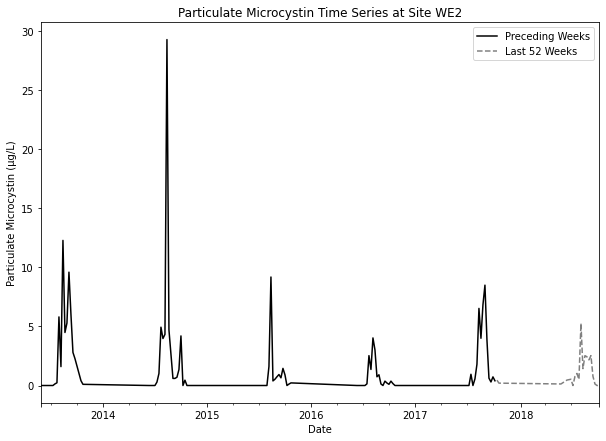

In [19]:
plt.figure(figsize = (10, 7))
ts['Particulate Microcystin (µg/L)'].head(ts.shape[0] - 52).plot(color = 'k', label = 'Preceding Weeks')
ts['Particulate Microcystin (µg/L)'].tail(52).plot(color = 'gray', linestyle = '--', label = 'Last 52 Weeks')
plt.title('Particulate Microcystin Time Series at Site WE2')
plt.legend();
plt.ylabel('Particulate Microcystin (µg/L)');

Data is extremely seasonal. Examine seasonal decomposition of target variable: <br>
We see that there is a spike in Particulate Microcystin during summer of each year, and that 2014 and 2015 were the most extreme years. The seasonal component is an order of magnitude larger than the trend component.

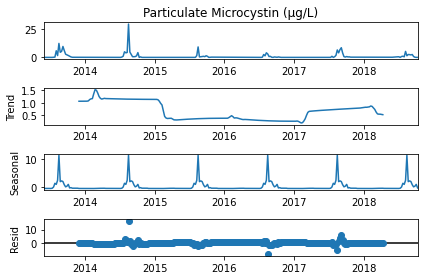

In [24]:
seasonal_decompose(ts['Particulate Microcystin (µg/L)']).plot();

Plot the auto correlation lags and partial autocorrelation lags for the target variable. We can see that lags of 1, 2, 3, 49, and 52 are significantly correlated with the target variable at lag 0; i.e. the values from a couple weeks ago and the values from about a year ago can be used to predict the values of this week.

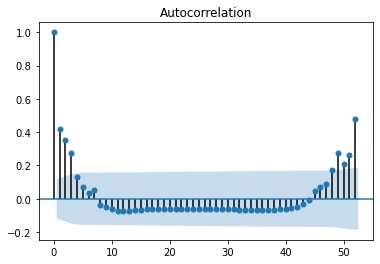

In [25]:
plot_acf(ts['Particulate Microcystin (µg/L)'], lags = 52);

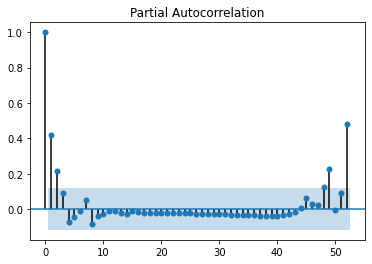

In [26]:
plot_pacf(ts['Particulate Microcystin (µg/L)'], lags = 52);

There appears to be no long-term trends in the target variable, and the low p-value of the Augmented Dickey-Fuller Test provided additional evidence that the data can be considered stationary.

In [39]:
pd.DataFrame(adfuller(ts['Particulate Microcystin (µg/L)'])[0:2], index=['Test Statistic','p-value'])

,0
Test Statistic,-7.191639e+00
p-value,2.494817e-10


Create autoregressed time series based on significant lags from partial autocorrelation function.

In [87]:
ar_ts = pd.concat([
    ts[['Particulate Microcystin (µg/L)']], 
    ts[['Particulate Microcystin (µg/L)']].shift(1).rename(columns = {'Particulate Microcystin (µg/L)': 'Lag_1'}),
    ts[['Particulate Microcystin (µg/L)']].shift(2).rename(columns = {'Particulate Microcystin (µg/L)': 'Lag_2'}),
    ts[['Particulate Microcystin (µg/L)']].shift(3).rename(columns = {'Particulate Microcystin (µg/L)': 'Lag_3'}),
    ts[['Particulate Microcystin (µg/L)']].shift(49).rename(columns = {'Particulate Microcystin (µg/L)': 'Lag_49'}),
    ts[['Particulate Microcystin (µg/L)']].shift(52).rename(columns = {'Particulate Microcystin (µg/L)': 'Lag_52'}),
          ], axis = 1).dropna()

In [88]:
X_train = ar_ts.drop(columns = ['Particulate Microcystin (µg/L)']).head(ar_ts.shape[0] - 52)
y_train = ar_ts['Particulate Microcystin (µg/L)'].head(ar_ts.shape[0] - 52)
X_test = ar_ts.drop(columns = ['Particulate Microcystin (µg/L)']).tail(52)
y_test = ar_ts['Particulate Microcystin (µg/L)'].tail(52)

Fit linear model on lagged data, plot predictions against actual values.

In [96]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
ar_model = sm.OLS(y_train, X_train).fit()

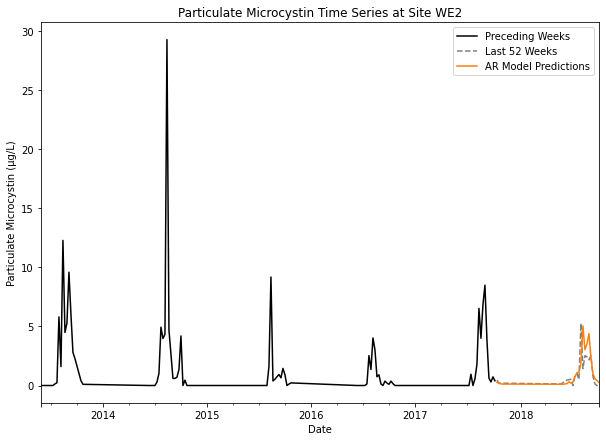

In [97]:
plt.figure(figsize = (10, 7))
ts['Particulate Microcystin (µg/L)'].head(ts.shape[0] - 52).plot(color = 'k', label = 'Preceding Weeks')
ts['Particulate Microcystin (µg/L)'].tail(52).plot(color = 'gray', linestyle = '--', label = 'Last 52 Weeks')
ar_model.predict(X_test).plot(color = 'tab:orange', label = 'AR Model Predictions')
plt.title('Particulate Microcystin Time Series at Site WE2')
plt.legend();
plt.ylabel('Particulate Microcystin (µg/L)');

Root mean squared error for the last 52 weeks for the autoregressive model:

In [99]:
mean_squared_error(y_test, ar_model.predict(X_test)) ** 0.5

0.7848867576503165